# 0.0 Imports

## 0.1 Imports

In [5]:
import pandas as pd
from  pyspark.sql import SparkSession

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

## 0.2 Starting Spark Session

In [6]:
spark = (SparkSession
.builder
.appName('Fraud')
.getOrCreate())

spark

## 0.3 Helper Functions



In [7]:
import matplotlib.pyplot as plt

def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16
    plt.rcParams['figure.facecolor'] = 'white'
    
    # display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    # sns.set()

jupyter_settings()

def proba_to_pandas(dataframe, prob_col:str, label_col:str):
    """
    Converts a PySpark SQL DataFrame's probability and label columns to a pandas dataframe.
    """
    # convert to pandas df
    result = dataframe.select([prob_col, label_col]).toPandas()
    
    # rename cols
    result.columns = ['y_pred', 'y_true']

    # select proba of positive class
    result['y_pred'] = result['y_pred'].apply(lambda x : x[1])
    
    return result

## 0.4 Data Loading

In [8]:
%%time
data = spark.read.csv('../data/raw/fraud.csv', header = True, inferSchema=True)

CPU times: user 7.64 ms, sys: 8.8 ms, total: 16.4 ms
Wall time: 16.9 s


In [9]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [10]:
type(data)

pyspark.sql.dataframe.DataFrame

In [11]:
data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

## 0.5 Columns Description



**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** -
amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1.0 Data Description


## 1.1 Rename Columns

## 1.2 Data Dimensions

## 1.3 Data Types

## 1.4 NA Check

In [12]:
data.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [13]:
columns = data.columns


NAs = {col: data[data[col].isNull()].count() for col in columns }

NAs

{'step': 0,
 'type': 0,
 'amount': 0,
 'nameOrig': 0,
 'oldbalanceOrg': 0,
 'newbalanceOrig': 0,
 'nameDest': 0,
 'oldbalanceDest': 0,
 'newbalanceDest': 0,
 'isFraud': 0,
 'isFlaggedFraud': 0}

## 1.5 NA Fillout

## 1.6 Changing Data Types


In [14]:
data.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



## 1.7 Descriptive Statistics

### 1.7.1 Numerical Attributes

In [15]:
desc = data.describe().toPandas()

In [16]:
desc = desc.T
cols = list(desc.loc['summary', :])
cols

rename_cols = dict(zip(desc.columns, cols))
rename_cols

desc.rename(columns = rename_cols, inplace = True)
desc = desc.drop('summary')

In [17]:
desc

,count,mean,stddev,min,max
step,6362620,243.39724563151657,142.33197104912588,1,743
type,6362620,None,None,CASH_IN,TRANSFER
amount,6362620,179861.90354913412,603858.2314629498,0.0,9.244551664E7
nameOrig,6362620,None,None,C1000000639,C999999784
oldbalanceOrg,6362620,833883.1040744719,2888242.673037545,0.0,5.958504037E7
newbalanceOrig,6362620,855113.6685785714,2924048.502954253,0.0,4.958504037E7
nameDest,6362620,None,None,C1000004082,M999999784
oldbalanceDest,6362620,1100701.6665196654,3399180.1129944855,0.0,3.5601588935E8
newbalanceDest,6362620,1224996.3982019408,3674128.9421195714,0.0,3.5617927892E8
isFraud,6362620,0.001290820448180152,0.035904796801604424,0,1


In [18]:
# spark.sql('select * from data')
prop = data.groupBy('isFraud').count().toPandas()
prop

,isFraud,count
0,1,8213
1,0,6354407


In [19]:
frauds = prop.iloc[0,1]
non_frauds = prop.iloc[1,1]

print('fraud percentage: {:.4f}%'.format( 100*frauds/(frauds+non_frauds)))


fraud percentage: 0.1291%


### 1.7.2 Categorical Attributes

# 2.0 Feature Engineering

## 2.1 Response Variable Mind Map

## 2.2 Hypothesis List

## 2.3 Selected Hypothesis:

**H1:** 

**H2:** 

**H3:** 

**H4:** 

**H5:** 

**H6:** 

**H7:** 

**H8:** 

**H9:** 

**H10:** 

**H11:** 

## 2.4 Feature Engineering

# 3.0 Variable Selection

In [20]:
# numerical variables

data.dtypes

[('step', 'int'),
 ('type', 'string'),
 ('amount', 'double'),
 ('nameOrig', 'string'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('nameDest', 'string'),
 ('oldbalanceDest', 'double'),
 ('newbalanceDest', 'double'),
 ('isFraud', 'int'),
 ('isFlaggedFraud', 'int')]

In [21]:
# Selecting cols and transformers to apply RF

# #('step', 'int'), use later
# ('type', 'string'), # OHE
# ('amount', 'double'), 
# # ('nameOrig', 'string'),
# ('oldbalanceOrg', 'double'),
# ('newbalanceOrig', 'double'),
# # ('nameDest', 'string'),
# ('oldbalanceDest', 'double'),
# ('newbalanceDest', 'double'),
# ('isFraud', 'int'),
# # ('isFlaggedFraud', 'int')

num_cols = ['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
cat_cols = ['type']

# 4.0 Exploratory Data Analysis

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

### 4.1.2 Numerical Variables

### 4.1.3 Categorical Variables

## 4.2 Bivariate Analysis

### **H1.**

### **H2.**


### **H3.**

### **H4.**

### **H5.**

### **H6.**

### **H7.**

### **H8.**

### **H9.**

### **H10.**

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

### 4.3.2 Categorical Attributes

# 5.0 Data Preparation

In [22]:
data.show(5)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

## 5.1 Testing

In [23]:
df1 = data.sample(fraction=50/6350000, seed=42)

In [24]:
selected_cols = num_cols + ['type_ohe']

# type category to idx
string_indx = StringIndexer(inputCols=['type'], outputCols=['type_idx'])

# ohe of type category idx
ohe = OneHotEncoder(inputCols=['type_idx'], outputCols=['type_ohe'])

# join everything with untransformed numeric values
vec_asm = VectorAssembler(inputCols= selected_cols, outputCol='features')

# instantiating model
rf = RandomForestClassifier(featuresCol='features', labelCol='isFraud', seed=42, numTrees=10)

pipeline = Pipeline(stages=[string_indx, ohe, vec_asm, rf])

a = pipeline.fit(df1).transform(df1)
a.show()

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+--------+-------------+--------------------+-------------+-----------+----------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_idx|     type_ohe|            features|rawPrediction|probability|prediction|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+--------+-------------+--------------------+-------------+-----------+----------+
|  10| PAYMENT|  20662.66|C1256812995|      20160.0|           0.0|M1899322391|           0.0|           0.0|      0|             0|     0.0|(3,[0],[1.0])|(8,[0,1,5],[20662...|       [10.0]|      [1.0]|       0.0|
|  17| PAYMENT|   12607.2|C1031150070|      30159.0|       17551.8|M1462583307|           0.0|           0.0|      0|             0|     0.0|(3,

# 6.0 Feature Selection

## 6.1 Spliting Dataframe into Train Test 

In [25]:
# train test split yielding 80% 20% split, stratified on response variable

train = data.sampleBy( col='isFraud' ,fractions = {0:0.8, 1:0.8}, seed = 42 )
test = data.exceptAll(train)

In [26]:
# executing and verifying split results

train.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   6544|
|      0|5083314|
+-------+-------+



In [27]:
test.groupBy('isFraud').count().show()

22/04/23 19:19:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:19:38 WARN RowBasedKeyValueBatch: Calling spill() on

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   1669|
|      0|1271093|
+-------+-------+



In [28]:
data.unpersist()

DataFrame[step: int, type: string, amount: double, nameOrig: string, oldbalanceOrg: double, newbalanceOrig: double, nameDest: string, oldbalanceDest: double, newbalanceDest: double, isFraud: int, isFlaggedFraud: int]

In [29]:
spark.catalog.clearCache()

# 7.0 Model Testing

## 7.1 Random Forest

In [30]:
results = pipeline.fit(train).transform(test)

22/04/23 19:23:14 WARN MemoryStore: Not enough space to cache rdd_239_0 in memory! (computed 100.8 MiB so far)
22/04/23 19:23:14 WARN BlockManager: Persisting block rdd_239_0 to disk instead.
22/04/23 19:23:15 WARN MemoryStore: Not enough space to cache rdd_239_3 in memory! (computed 100.8 MiB so far)
22/04/23 19:23:15 WARN BlockManager: Persisting block rdd_239_3 to disk instead.
22/04/23 19:23:15 WARN MemoryStore: Not enough space to cache rdd_239_1 in memory! (computed 100.8 MiB so far)
22/04/23 19:23:15 WARN BlockManager: Persisting block rdd_239_1 to disk instead.
22/04/23 19:23:16 WARN MemoryStore: Not enough space to cache rdd_239_2 in memory! (computed 100.8 MiB so far)
22/04/23 19:23:16 WARN BlockManager: Persisting block rdd_239_2 to disk instead.
22/04/23 19:23:54 WARN MemoryStore: Not enough space to cache rdd_239_0 in memory! (computed 100.8 MiB so far)
22/04/23 19:23:54 WARN MemoryStore: Not enough space to cache rdd_239_1 in memory! (computed 100.8 MiB so far)
22/04/23 1

In [31]:
results.show()

22/04/23 19:25:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:25:38 WARN RowBasedKeyValueBatch: Calling spill() on

+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+--------+-------------+--------------------+--------------------+--------------------+----------+
|step|    type|    amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|type_idx|     type_ohe|            features|       rawPrediction|         probability|prediction|
+----+--------+----------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+--------+-------------+--------------------+--------------------+--------------------+----------+
|   1| PAYMENT|   2338.05| C835631769|      81955.0|      79616.95|  M43368234|           0.0|           0.0|      0|             0|     1.0|(4,[1],[1.0])|(9,[0,1,2,6],[233...|[9.99732743284800...|[0.99973274328480...|       0.0|
|   1|CASH_OUT| 276138.13|C1071933072|     177971.0|           0.0| C543409470| 

# 8.0. Checking model performance

In [32]:
results_pd = proba_to_pandas(dataframe = results, prob_col='probability', label_col='isFraud')

22/04/23 19:26:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:26:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:26:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:26:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:27:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:27:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:27:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/04/23 19:27:23 WARN RowBasedKeyValueBatch: Calling spill() on

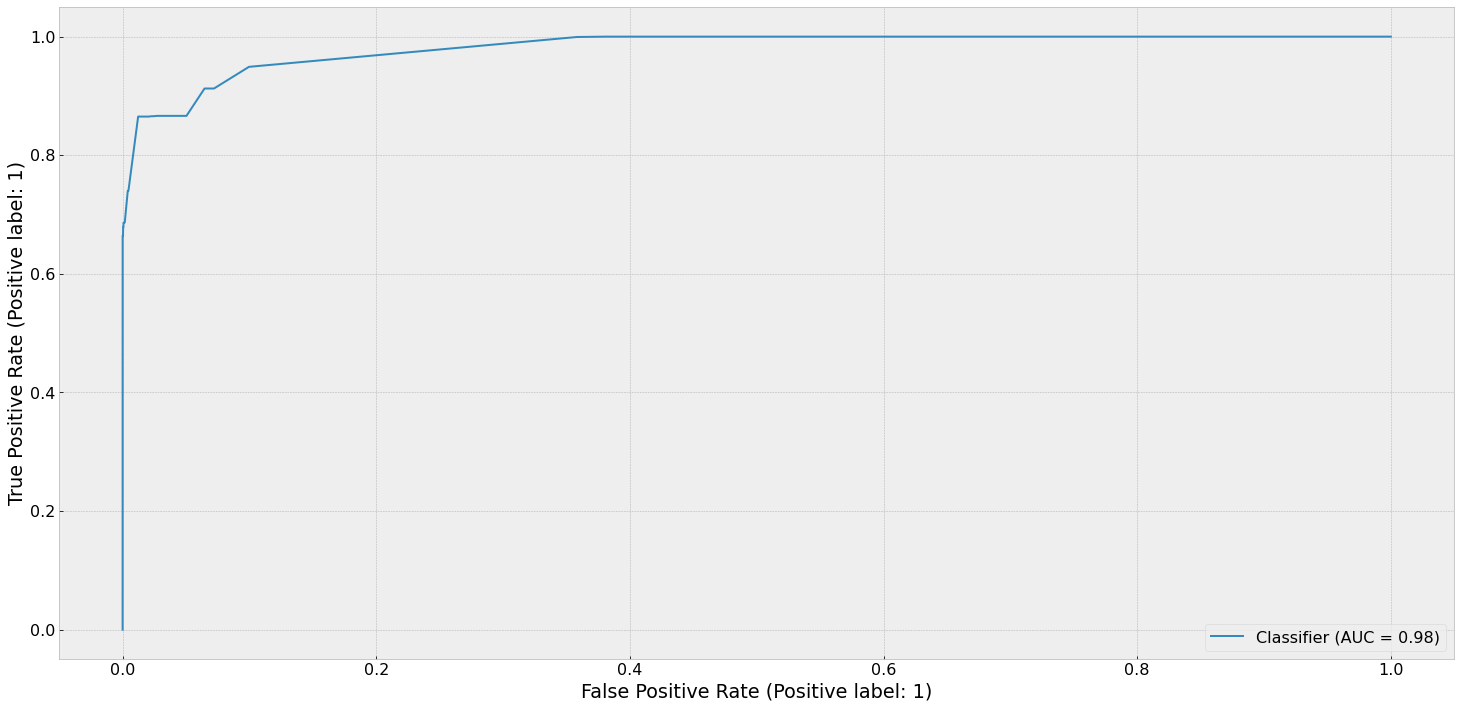

In [33]:
fig, ax = plt.subplots() #figsize = (25,12)
RocCurveDisplay.from_predictions(y_pred = results_pd.y_pred, y_true= results_pd.y_true, ax = ax);


In [36]:
results_pd.head()

,y_pred,y_true
0,0.000442,0
1,0.000442,0
2,0.000442,0
3,0.000442,0
4,0.000442,0


In [64]:
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
cm

array([[1271051,      42],
       [    560,    1109]])

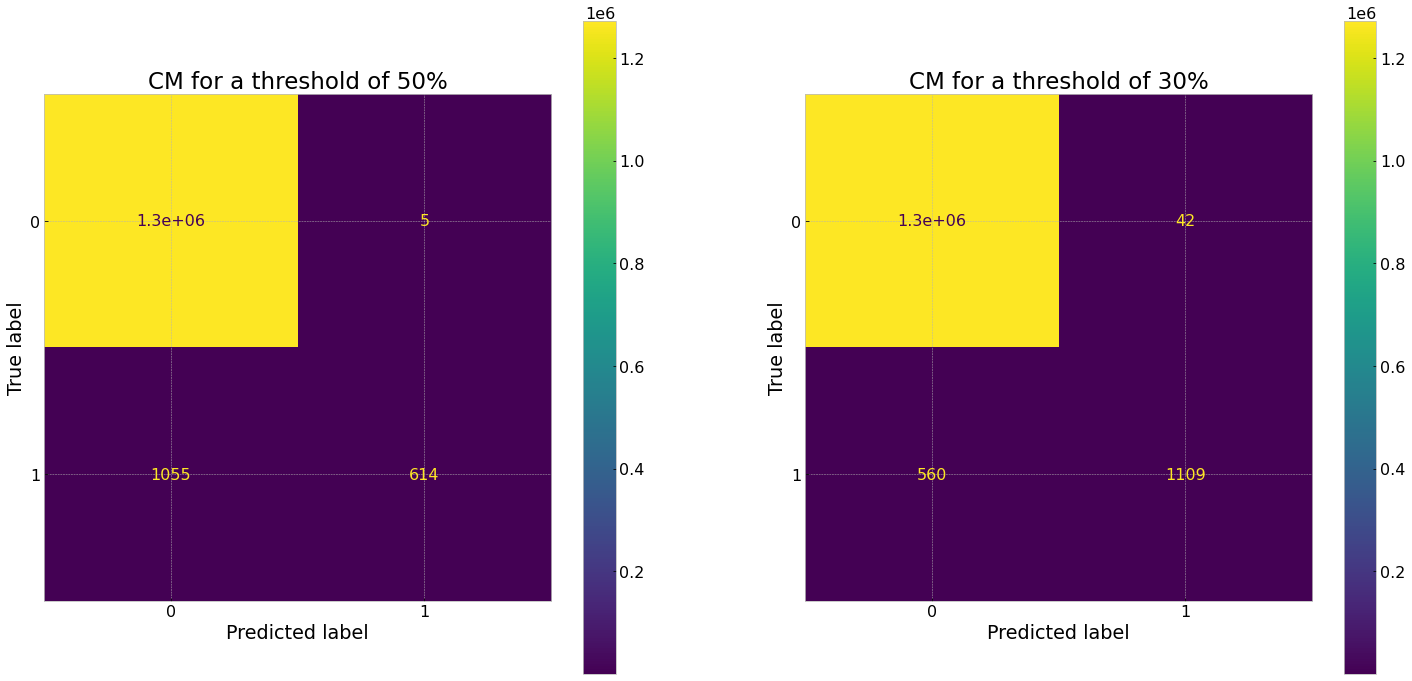

In [85]:
fig, ax = plt.subplots(1,2)

# 50 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.5)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[0])
ax[0].set_title('CM for a threshold of 50%')

# 30 % threshold
cm = confusion_matrix(y_true=results_pd.y_true, y_pred=results_pd.y_pred > 0.3)
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax = ax[1])
ax[1].set_title('CM for a threshold of 30%');

In [90]:
from sklearn.metrics import 

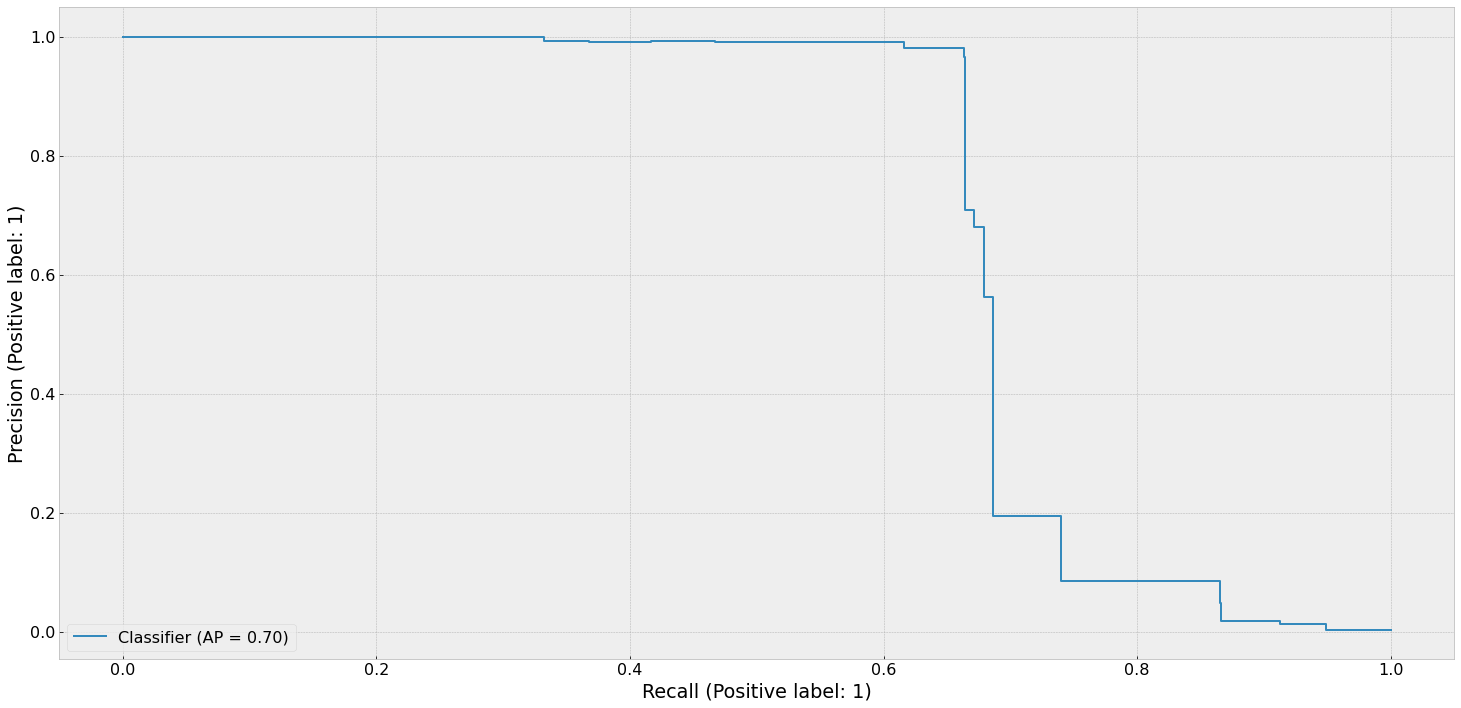

In [92]:
PrecisionRecallDisplay.from_predictions(y_true=results_pd.y_true, y_pred = results_pd.y_pred);

We could have a moderate recall (66%) with very high precision (96%) if we lower the threshold to 30% in our first model, as we may see from the confusion matrices and the PR curve.

In a real-world situation, we could use this model as an MVP and deploy it while building a more precise one. However, since I am using CRISP-DM, I'll consider this model as a baseline for the project and keep attempting to improve it.